In [20]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

class TicTacToe:
    def __init__(self):
        self.row_count = 3
        self.column_count = 3
        self.action_size = self.row_count * self.column_count

    def __repr__(self):
        return "TicTacToe"

    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count), dtype=int)
    
    def get_next_state(self, state, action, player):
        new_state = state.copy()
        row = action // self.column_count
        col = action % self.column_count
        new_state[row, col] = player
        return new_state
    
    def get_valid_moves(self, state):
        return (state.reshape(-1) == 0).astype(np.uint8)
    
    def check_win(self, state, action):
        if action == None:
            return False

        row = action // self.column_count
        col = action % self.column_count
        player = state[row, col]
        return (
            np.sum(state[row, :]) == player * self.column_count
            or np.sum(state[:, col]) == player * self.row_count
            or np.sum(np.diag(state)) == player * self.row_count
            or np.sum(np.diag(np.flip(state, axis=0))) == player * self.row_count
        )
    
    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        return 0, False
    
    def get_opponent(self, player):
        return -player
    
    def get_opponent_value(self, value):
        return -value
    
    def change_perspective(self, state, player):
        return state * player
    
    def get_encoded_state(self, state):
        encoded_state = np.stack([
            (state == -1).astype(np.float32),
            (state == 0).astype(np.float32),
            (state == 1).astype(np.float32)
        ])
        return encoded_state
 


In [2]:
# model architecture

import torch
print(torch.__version__)



torch.manual_seed(0)

2.7.0+cu118


In [3]:
# packages
%pip install tqdm

import math

from tqdm.notebook import trange
import random

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
class ConnectFour:
    def __init__(self):
        self.row_count = 6
        self.column_count = 7
        self.action_size = self.column_count
        self.in_a_row = 4

    def __repr__(self):
        return "ConnectFour"

    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count), dtype=int)
    
    def get_next_state(self, state, action, player):
        new_state = state.copy()
        row = np.max(np.where(state[:, action] == 0))
        new_state[row, action] = player
        return new_state
    
    def get_valid_moves(self, state):
        return (state[0] == 0).astype(np.uint8)
    
    def check_win(self, state, action):
        if action == None:
            return False

        row = np.min(np.where(state[:, action] != 0))
        column = action
        player = state[row][column]

        def count(offset_row, offset_column):
            for i in range(1, self.in_a_row):
                r = row + offset_row * i
                c = action + offset_column * i
                if (
                    r < 0 
                    or r >= self.row_count
                    or c < 0 
                    or c >= self.column_count
                    or state[r][c] != player
                ):
                    return i - 1
            return self.in_a_row - 1

        return (
            count(1, 0) >= self.in_a_row - 1 # vertical
            or (count(0, 1) + count(0, -1)) >= self.in_a_row - 1 # horizontal
            or (count(1, 1) + count(-1, -1)) >= self.in_a_row - 1 # top left diagonal
            or (count(1, -1) + count(-1, 1)) >= self.in_a_row - 1 # top right diagonal
        )
    
    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        return 0, False
    
    def get_opponent(self, player):
        return -player
    
    def get_opponent_value(self, value):
        return -value
    
    def change_perspective(self, state, player):
        return state * player
    
    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)
        
        if len(state.shape) == 3:
            encoded_state = np.swapaxes(encoded_state, 0, 1)
        
        return encoded_state

In [4]:
# residual network (ResNet)

import torch.nn as nn
import torch.nn.functional as F

class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden, device):
        super().__init__()

        self.device = device
        self.startBlock = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )

        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for _ in range(num_resBlocks)]
        )

        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.row_count * game.column_count, game.action_size)
        )

        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.column_count, 1),
            nn.Tanh()
        )

        self.to(device)

    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)

        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value


class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x


0.9771323204040527
[[ 0  0 -1]
 [ 0 -1  0]
 [ 1  0  1]]
tensor([[[[0., 0., 1.],
          [0., 1., 0.],
          [0., 0., 0.]],

         [[1., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [1., 0., 1.]]]], device='cuda:0')


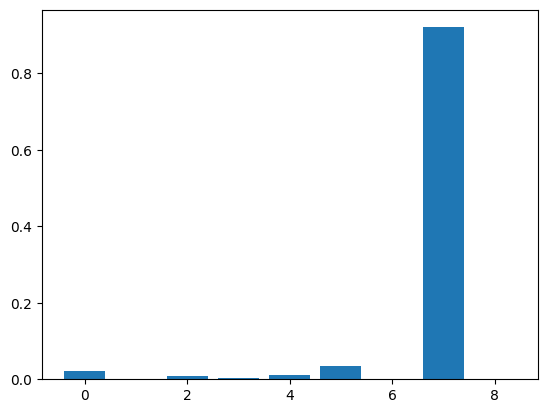

In [19]:
import matplotlib.pyplot as plt

ttt = TicTacToe()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state = ttt.get_initial_state()

state = ttt.get_next_state(state, 2, -1)
state = ttt.get_next_state(state, 4, -1)

state = ttt.get_next_state(state, 6, 1)
state = ttt.get_next_state(state, 8, 1)

encoded_state = ttt.get_encoded_state(state)

tensor_state = torch.tensor(encoded_state, device=device).unsqueeze(0)

model = ResNet(ttt, 4, 64, device=device)
model.load_state_dict(torch.load('model_2.pt', map_location=device))
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print(value)

print(state)
print(tensor_state)

plt.bar(range(ttt.action_size), policy)
plt.show()

In [16]:

import math
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0, visit_count=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior

        self.children = []
        # self.expandable_moves = game.get_valid_moves(state)

        self.visit_count = visit_count
        self.value_sum = 0

    def is_fully_expanded(self):
        return len(self.children) > 0

    def select(self):
        best_ucb = float('-inf')
        best_child = None

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_ucb = ucb
                best_child = child

        return best_child

    
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior
    
    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:

            # action = np.random.choice(np.where(self.expandable_moves == 1)[0])
            # self.expandable_moves[action] = 0

                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action, 1)

                child_state = self.game.change_perspective(child_state, player=-1)

                child = Node(self.game, self.args, child_state, self, action, prob)

                self.children.append(child)
        # return child
    
    '''def simulate(self):
        value, is_terminal = self.game.get_value_and_terminated(self.state, self.action_taken)
        value = self.game.get_opponent_value(value)

        if is_terminal:
            return value
        rollout_state = self.state.copy()
        rollout_player = 1

        while True:
            valid_moves = self.game.get_valid_moves(rollout_state)
            action = np.random.choice(np.where(valid_moves == 1)[0])
            rollout_state = self.game.get_next_state(rollout_state, action, rollout_player)
            value, is_terminal = self.game.get_value_and_terminated(rollout_state, action)

            if is_terminal:
                if rollout_player == -1:
                    value = self.game.get_opponent_value(value)
                return value
            
            rollout_player = self.game.get_opponent(rollout_player)'''
        
    def backpropogate(self, value):
        self.value_sum += value
        self.visit_count += 1

        value = self.game.get_opponent_value(value)

        if self.parent is not None:
            self.parent.backpropogate(value)

class MCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model

    @torch.no_grad()
    def search(self, state):
        # define root node
        root = Node(self.game, self.args, state, visit_count=1)

        # get initial policy from the neural net
        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(state),
                         device=self.model.device).unsqueeze(0)
        )
        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()

        # add Dirichlet noise for exploration
        policy = (
            (1 - self.args['dirichlet_epsilon']) * policy
            + self.args['dirichlet_epsilon']
              * np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size)
        )

        # ← use root.state here, not node.state
        valid_moves = self.game.get_valid_moves(root.state)
        policy *= valid_moves
        policy /= np.sum(policy)

        root.expand(policy)

        # run MCTS simulations
        for _ in range(self.args['num_searches']):
            node = root

            # selection: descend the tree until we reach a not-fully-expanded node
            while node.is_fully_expanded():
                node = node.select()

            # get value & terminal flag for this node
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)

            if not is_terminal:
                # expand & evaluate with the network
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state),
                                 device=self.model.device).unsqueeze(0)
                )
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = self.game.get_valid_moves(node.state)
                policy *= valid_moves
                policy /= np.sum(policy)
                value = value.item()

                node.expand(policy)

            # backpropagate the value up the tree
            node.backpropogate(value)

        # compute the final action probabilities
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)

        return action_probs



In [45]:
class AlphaZero:
    def __init__(self, model, optimizer, game, args):
        self.model     = model
        self.optimizer = optimizer
        self.game      = game
        self.args      = args
        self.mcts      = MCTS(game, args, model)

    def selfPlay(self):
        memory = []
        player  = 1
        state   = self.game.get_initial_state()

        # play one game to completion, storing (state, policy, player)
        while True:
            neutral_state = self.game.change_perspective(state, player)
            action_probs  = self.mcts.search(neutral_state)

            memory.append((neutral_state, action_probs, player))
            
            temperature_action_probs = action_probs ** (1 / self.args['temperature'])

            action = np.random.choice(self.game.action_size, p=action_probs)
            state  = self.game.get_next_state(state, action, player)

            value, is_terminal = self.game.get_value_and_terminated(state, action)
            if is_terminal:
                break

        # at the end: package training samples with the final reward
        training_data = []
        for hist_state, hist_pi, hist_player in memory:
            outcome = value if hist_player == player else self.game.get_opponent_value(value)
            training_data.append((
                self.game.get_encoded_state(hist_state),
                hist_pi,
                outcome
            ))
        return training_data

    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx + self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample)

            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)

            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)

            out_policy, out_value = self.model(state)

            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets) 

            loss = policy_loss + value_loss

            #backprop
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def learn(self):
        for iteration in range(self.args['num_iterations']):
            # 1) Self-play to build up memory
            memory = []
            self.model.eval()
            for _ in range(self.args['num_selfPlay_iterations']):
                memory += self.selfPlay()

            # 2) Train for num_epochs over that memory
            self.model.train()
            for epoch in range(self.args['num_epochs']):
                # you’ll likely want to sample minibatches here,
                # but at minimum:
                self.train(memory)

            # 3) Save checkpoints
            torch.save(self.model.state_dict(),     f"model_{iteration}_{self.game}.pt")
            torch.save(self.optimizer.state_dict(), f"optim_{iteration}_{self.game}.pt")


            

In [52]:


class MCTSParallel:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model
        
    @torch.no_grad()
    def search(self, raw_states, spGames):
        B = raw_states.shape[0]

        # 1) Batch‐encode each (H,W) board → (B, C, H, W)
        encoded = np.stack([ self.game.get_encoded_state(s) for s in raw_states ], axis=0)
        t_encoded = torch.tensor(encoded, dtype=torch.float32, device=self.model.device)

        # 2) Initial policy + Dirichlet noise
        logits, _ = self.model(t_encoded)                       # (B, A), _
        policy = torch.softmax(logits, dim=1).cpu().numpy()     # (B, A)
        noise  = np.random.dirichlet([self.args['dirichlet_alpha']]*self.game.action_size, size=B)
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] * noise

        # 3) Initialize roots
        for i, spg in enumerate(spGames):
            pm = policy[i]
            valid = self.game.get_valid_moves(raw_states[i])
            pm *= valid; pm /= pm.sum()
            spg.root = Node(self.game, self.args, raw_states[i], visit_count=1)
            spg.root.expand(pm)

        # 4) MCTS sims
        for _ in range(self.args['num_searches']):
            # selection
            for spg in spGames:
                spg.node = None
                node = spg.root
                while node.is_fully_expanded():
                    node = node.select()

                v, terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
                v = self.game.get_opponent_value(v)
                if terminal:
                    node.backpropogate(v)
                else:
                    spg.node = node

            # expansion + evaluation in batch
            idxs = [i for i, spg in enumerate(spGames) if spg.node is not None]
            if not idxs:
                continue

            new_states = np.stack([spGames[i].node.state for i in idxs], axis=0)
            enc2 = np.stack([self.game.get_encoded_state(s) for s in new_states], axis=0)
            t2 = torch.tensor(enc2, dtype=torch.float32, device=self.model.device)

            logits2, vals2 = self.model(t2)                     # (M, A), (M,1)
            policy2 = torch.softmax(logits2, dim=1).cpu().numpy()
            vals   = vals2.cpu().numpy().flatten()

            for idx, game_idx in enumerate(idxs):
                node = spGames[game_idx].node
                pm2 = policy2[idx]
                valid = self.game.get_valid_moves(node.state)
                pm2 *= valid; pm2 /= pm2.sum()
                node.expand(pm2)
                node.backpropogate(vals[idx])

In [53]:



class AlphaZeroParallel:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTSParallel(game, args, model)
        
    def selfPlay(self):
        memory = []
        player = 1
        spGames = [SPG(self.game) for _ in range(self.args['num_parallel_games'])]

        while spGames:
            raw_states = np.stack([spg.state for spg in spGames])
            raw_states = self.game.change_perspective(raw_states, player)

            # parallel MCTS
            self.mcts.search(raw_states, spGames)

            # advance each game
            for i in range(len(spGames)-1, -1, -1):
                spg = spGames[i]
                # visit‐count → action_probs
                ap = np.zeros(self.game.action_size)
                for c in spg.root.children:
                    ap[c.action_taken] = c.visit_count
                ap /= ap.sum()
                spg.memory.append((spg.root.state, ap, player))

                # sample with temperature
                tp = ap ** (1/self.args['temperature']); tp /= tp.sum()
                a = np.random.choice(self.game.action_size, p=tp)

                spg.state = self.game.get_next_state(spg.state, a, player)
                v, done = self.game.get_value_and_terminated(spg.state, a)

                if done:
                    for hs, hap, hp in spg.memory:
                        outcome = v if hp==player else self.game.get_opponent_value(v)
                        # store encoded for training
                        memory.append(( self.game.get_encoded_state(hs), hap, outcome ))
                    spGames.pop(i)

            player = self.game.get_opponent(player)

        return memory
                
    def train(self, memory):
        random.shuffle(memory)
        for start in range(0, len(memory), self.args['batch_size']):
            batch = memory[start:start+self.args['batch_size']]
            states, pols, vals = zip(*batch)

            s = torch.tensor(np.array(states), dtype=torch.float32, device=self.model.device)
            p = torch.tensor(np.array(pols),   dtype=torch.float32, device=self.model.device)
            v = torch.tensor(np.array(vals).reshape(-1,1),
                             dtype=torch.float32, device=self.model.device)

            out_p, out_v = self.model(s)
            loss = F.cross_entropy(out_p, p) + F.mse_loss(out_v, v)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
    
    def learn(self):
        for it in range(self.args['num_iterations']):
            # self-play
            self.model.eval()
            mem = []
            n = self.args['num_selfPlay_iterations'] // self.args['num_parallel_games']
            for _ in trange(n, desc="Self-play"):
                mem += self.selfPlay()

            # training
            self.model.train()
            for _ in trange(self.args['num_epochs'], desc="Training"):
                self.train(mem)

            # save
            cls = self.game.__class__.__name__
            torch.save(self.model.state_dict(),     f"model_{it}_{cls}.pt")
            torch.save(self.optimizer.state_dict(), f"opt_{it}_{cls}.pt")


class SPG:
    def __init__(self, game):
        self.state = game.get_initial_state()
        self.memory = []
        self.root = None
        self.node = None



In [ ]:
ttt = TicTacToe()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(ttt, 4, 64, device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = {
    'C' : 2,
    'num_searches': 60,
    'num_iterations': 3,
    'num_selfPlay_iterations': 500,
    'num_epochs': 4,
    'batch_size': 64,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

alphazero = AlphaZero(model, optimizer, ttt, args)

import time

start = time.time()
alphazero.learn()
end   = time.time()

elapsed_seconds = end - start
print(f"Total training took {elapsed_seconds:.2f} seconds "
      f"({elapsed_seconds/60:.2f} minutes).")


KeyboardInterrupt: 

In [54]:
c4 = ConnectFour()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model     = ResNet(c4, 9, 128, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

args = {
    'C'                    : 2,
    'num_searches'         : 600,
    'num_iterations'       : 8,
    'num_selfPlay_iterations': 500,
    'num_parallel_games'   : 100,
    'num_epochs'           : 4,
    'batch_size'           : 128,
    'temperature'          : 1.25,
    'dirichlet_epsilon'    : 0.25,
    'dirichlet_alpha'      : 0.3
}

alphazero = AlphaZeroParallel(model, optimizer, c4, args)

start = time.time()
alphazero.learn()
end   = time.time()
print(f"Total training took {end-start:.2f}s ({(end-start)/60:.2f}m).")


Self-play:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np

# Setup
ttt = TicTacToe()
player = 1
args = {
    'C': 2,
    'num_searches': 1000,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.03
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(ttt, 4, 64, device=device)
model.eval()

mcts = MCTS(ttt, args, model)
state = ttt.get_initial_state()

# Create 9 buttons
buttons = [
    widgets.Button(description='', layout=widgets.Layout(width='60px', height='60px'))
    for _ in range(ttt.action_size)
]

grid = widgets.GridBox(
    buttons,
    layout=widgets.Layout(
        grid_template_columns='repeat(3, 60px)',
        grid_gap='5px',
    )
)

status = widgets.HTML(value=f"<b>Player {player}’s turn</b>")

def on_click(b):
    global state, player

    idx = buttons.index(b)
    valid_moves = ttt.get_valid_moves(state)
    if not valid_moves[idx]:
        status.value = f"<span style='color:red;'>Cell occupied!</span>"
        return

    # Human move
    state = ttt.get_next_state(state, idx, player)
    b.disabled = True
    b.description = 'X' if player == 1 else 'O'

    value, is_terminal = ttt.get_value_and_terminated(state, idx)
    if is_terminal:
        status.value = f"<h3>{'X' if player==1 else 'O'} wins! 🎉</h3>" if value==1 else "<h3>Draw!</h3>"
        for btn in buttons: btn.disabled = True
        return

    # AI move
    player = -player
    status.value = f"<b>AI is thinking...</b>"

    neutral_state = ttt.change_perspective(state, player)
    mcts_probs = mcts.search(neutral_state)
    ai_action = int(np.argmax(mcts_probs))

    state = ttt.get_next_state(state, ai_action, player)
    buttons[ai_action].disabled = True
    buttons[ai_action].description = 'O' if player==-1 else 'X'

    value, is_terminal = ttt.get_value_and_terminated(state, ai_action)
    if is_terminal:
        status.value = f"<h3>{'O' if player==-1 else 'X'} wins! 🎉</h3>" if value==1 else "<h3>Draw!</h3>"
        for btn in buttons: btn.disabled = True
    else:
        player = -player
        status.value = f"<b>Player {player}’s turn</b>"

for btn in buttons:
    btn.on_click(on_click)

display(grid, status)



GridBox(children=(Button(layout=Layout(height='60px', width='60px'), style=ButtonStyle()), Button(layout=Layou…

HTML(value='<b>Player 1’s turn</b>')

In [38]:
c4 = ConnectFour()                       # your ConnectFour game class
player = 1                               # 1 = human, -1 = AI
args = {
    'C': 2,
    'num_searches': 1000,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.03
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(c4, 4, 64, device=device)  # adjust ResNet args as needed
# model.load_state_dict(torch.load("model_0_ConnectFour.pt", map_location=device))
model.eval()
mcts = MCTS(c4, args, model)

# get initial state and its shape
state = c4.get_initial_state()           # should be a 2D array, shape (rows, cols)
rows, cols = state.shape

# ----- Build the UI -----
# 1) Drop buttons (one per column)
drop_buttons = [
    widgets.Button(description="▼", layout=widgets.Layout(width='40px'))
    for _ in range(cols)
]

# 2) Cell grid (rows × cols)
cell_buttons = [
    widgets.Button(description=' ', disabled=True,
                   layout=widgets.Layout(width='40px', height='40px'))
    for _ in range(rows * cols)
]

# Layout containers
drop_bar = widgets.HBox(drop_buttons)
grid = widgets.GridBox(
    cell_buttons,
    layout=widgets.Layout(
        grid_template_columns=f'repeat({cols}, 40px)',
        grid_template_rows=f'repeat({rows}, 40px)',
        grid_gap='2px'
    )
)
status = widgets.HTML(value=f"<b>Player {player}’s turn</b>")

def render_board(state):
    """Update the rows×cols grid display from the 2D `state` array."""
    flat = state.flatten()
    for idx, val in enumerate(flat):
        btn = cell_buttons[idx]
        if val ==  1:
            btn.description = 'X'
            btn.button_style = 'primary'
        elif val == -1:
            btn.description = 'O'
            btn.button_style = 'danger'
        else:
            btn.description = ' '
            btn.button_style = ''

# Initial render
render_board(state)
display(drop_bar, grid, status)

# ----- Game Logic -----
def on_drop(b):
    global state, player

    col = drop_buttons.index(b)
    valid = c4.get_valid_moves(state)
    if not valid[col]:
        status.value = "<span style='color:red;'>Column full!</span>"
        return

    # Human drop
    state = c4.get_next_state(state, col, player)
    render_board(state)
    value, term = c4.get_value_and_terminated(state, col)
    if term:
        status.value = f"<h3>{'X' if player==1 else 'O'} wins! 🎉</h3>" if value==1 else "<h3>Draw!</h3>"
        for btn in drop_buttons: btn.disabled = True
        return

    # AI move
    player = -player
    status.value = f"<b>AI is thinking...</b>"
    neutral = c4.change_perspective(state, player)
    probs = mcts.search(neutral)
    ai_col = int(np.argmax(probs))

    state = c4.get_next_state(state, ai_col, player)
    render_board(state)
    value, term = c4.get_value_and_terminated(state, ai_col)
    if term:
        status.value = f"<h3>{'O' if player==-1 else 'X'} wins! 🎉</h3>" if value==1 else "<h3>Draw!</h3>"
        for btn in drop_buttons: btn.disabled = True
    else:
        player = -player
        status.value = f"<b>Player {player}’s turn</b>"

# Wire up drop buttons
for btn in drop_buttons:
    btn.on_click(on_drop)

GridBox(children=(Button(description=' ', disabled=True, layout=Layout(height='40px', width='40px'), style=But…

HTML(value='<b>Player 1’s turn</b>')

In [66]:
%pip install pettingzoo



  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
   ---------------------------------------- 0.0/847.8 kB ? eta -:--:--
   ---------------------------------------- 847.8/847.8 kB 3.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/965.4 kB ? eta -:--:--
   -------------------------------- ------- 786.4/965.4 kB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 965.4/965.4 kB 3.5 MB/s eta 0:00:00
Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)
Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)

   -------------------- ------------------- 2/4 [gymnasium]
   ------------------------------ --------- 3/4 [pettingzoo]
   ------------------------------ --------- 3/4 [pettingzoo]
   ---------------------------------------- 4/4 [pettingzoo]

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.17.2 requires Flask>=1.1.2, which is not installed.
kaggle-environments 1.17.2 requires open_spiel>=1.5.0, which is not installed.
kaggle-environments 1.17.2 requires scipy>=1.11.2, which is not installed.
kaggle-environments 1.17.2 requires shimmy>=1.2.1, which is not installed.
kaggle-environments 1.17.2 requires stable-baselines3==2.1.0, which is not installed.
kaggle-environments 1.17.2 requires gymnasium==0.29.0, but you have gymnasium 1.1.1 which is incompatible.
kaggle-environments 1.17.2 requires pettingzoo==1.24.0, but you have pettingzoo 1.24.3 which is incompatible.


In [72]:
import kaggle_environments
print(kaggle_environments.__version__)
from kaggle_environments import make
from kaggle_environments import evaluate

class KaggleAgent:
    def __init__(self, model, game, args):
        self.model = model
        self.game = game
        self.args = args
        if self.args.get('search', True):
            self.mcts = MCTS(self.game, self.args, self.model)

    def run(self, obs, conf):
        # obs["board"] is flat list length rows*cols
        rows, cols = self.game.row_count, self.game.column_count
        state = np.array(obs['board']).reshape(rows, cols)
        # Kaggle uses marks 1 and 2
        state[state == 2] = -1
        player = 1 if obs['mark'] == 1 else -1

        # perspective
        state = self.game.change_perspective(state, player)

        if self.args.get('search', True):
            policy = self.mcts.search(state)
        else:
            policy, _ = self.model.predict(state, augment=self.args.get('augment', False))

        valid = self.game.get_valid_moves(state)
        policy *= valid
        policy /= policy.sum()

        temp = self.args.get('temperature', 1.0)
        if temp == 0:
            action = int(np.argmax(policy))
        elif temp == float('inf'):
            choices = [i for i, p in enumerate(policy) if p > 0]
            action = int(np.random.choice(choices))
        else:
            p2 = policy ** (1 / temp)
            p2 /= p2.sum()
            action = int(np.random.choice(len(p2), p=p2))

        return action

# Instantiate your model and game:
c4 = ConnectFour()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(c4, 4, 64, device=device)
# model.load_state_dict(torch.load("model_0_ConnectFour.pt", map_location=device))
model.eval()

args = {
    'C': 2,
    'num_searches': 1000,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.03,
    'search': True,
    'temperature': 1.0
}

# Build the Kaggle ConnectX environment
env = make(
    "connectx",
    configuration={
        "rows": c4.row_count,
        "columns": c4.column_count,
        "inarow": c4.in_a_row
    },
    debug=True
)

# Create two copies of your agent
agent1 = KaggleAgent(model, c4, args)
agent2 = KaggleAgent(model, c4, args)

# Run and render
env.run([agent1.run, agent2.run])
env.render(mode="ipython")

1.17.2
